# Predict ADs on new TFs

- "makeTilingDF" part takes the input TF list, chops into 39 AA 'tiles' spaced every 1 AA. It also computes some parameters on each 39 AA tile.

- In parallel, "makeFullLengthProteinDF" builds a DataFrame of full length TFs. It uses this later to combine overlapping tiles

- Next, "ThresholdProteome_withaLine" identifies the 'tiles' that balance acidic and hydrophobic resiudes similarly to VP16 and CITED2. 

- "maskproteome" is the helper function that runs "ThresholdProteome_withaLine." It is left over from when we were trying different iterations/modifications of the predictor. 

- Finally, "AggregateTilesIntoPredictedADs" combines the tiles into predicted ADs. Note it has on occasion messed up but I think it is fixed now. 

In [1]:
import numpy as np
import protfasta
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib.pyplot import figure
import os
import warnings
warnings.filterwarnings('ignore')

# Master control variables (input and output files)

In [2]:
# Fasta File with proteins to scan for activation domains
inputfilename = '../data/LambertTFs.fasta'

# Where to save predictions
exportfilename='../output/predictions_toshare'

# Functions

In [3]:
# extract 39 AA windows from all TFs in a FASTA file
def makeTilingDF(inputfilename,window_size = 39, window_spacing = 1,AAs = ['W','F','Y','M','L','Q']):
    import os.path
    from os import path
    import re

    tilingDFs = os.listdir("../data/TilingDFs/")
    df=inputfilename.split("/")[-1].split(".")[0]

    AA_string=""
    for AA in AAs:
        AA_string+="(?=.+"+AA+")"

    regexp = re.compile(df+".+size_"+str(window_size)+".+space_"+str(window_spacing)+r'.+AAs.+'+AA_string+'.+')

    newlist = list(filter(regexp.match, tilingDFs)) 

    filepath="../data/TilingDFs/"+inputfilename.split("/")[-1].split(".")[0]+"_size_"+str(window_size)+"_space_"+str(window_spacing)+"_AAs_"+",".join(AAs)+".csv"
    
    if bool(newlist):
        print("Using existing Tiling DF at ../data/TilingDFs/"+newlist[0])
        return pd.read_csv("../data/TilingDFs/"+newlist[0],index_col=0)
    else:       
        print("Creating new Tiling DF at ",filepath)     
        ProteomeDict=protfasta.read_fasta(inputfilename, return_list=False, 
                                    invalid_sequence_action='ignore',
                                    duplicate_record_action='ignore',
                                    duplicate_sequence_action='ignore',
                                expect_unique_header=False)
        
        TilingWindows,ProteinNames,IUpredScores,Npos,Cpos = [],[],[],[],[]

        for gene in ProteomeDict:
                # take tilingwindows
                line = ProteomeDict[gene]
                if len(line)<window_size:
                    subset = line
                    Npos.append(0),Cpos.append(len(line))
                    TilingWindows.append(subset)
                    ProteinNames.append(gene)
                else:
                    for i in np.arange(0,len(line)-window_size+window_spacing,window_spacing):
                        subset = line[i:i+window_size]
                        Npos.append(i),Cpos.append(i+window_size)
                        TilingWindows.append(subset)
                        ProteinNames.append(gene)

        print("Window Size = %i  and Window spacing = %i" % (window_size, window_spacing))
        print("Number of Tiling Windows: %i" %len(TilingWindows))

        ProteomeDF = pd.DataFrame({'ProteinWindowSeq':TilingWindows,'GeneName':ProteinNames,
                                'StartPosition':Npos,'EndPosition':Cpos})
        
        #count important AAs
        for aa in AAs:
            ProteomeDF[aa]= ProteomeDF.apply(lambda row: row['ProteinWindowSeq'].count(aa),axis=1)
        
        #compute net charge
        ProteomeDF['Charge'] = ProteomeDF.apply(lambda row: row['ProteinWindowSeq'].count('K')+row['ProteinWindowSeq'].count('R')-row['ProteinWindowSeq'].count('D')-row['ProteinWindowSeq'].count('E'),axis=1)

        ProteomeDF.to_csv(filepath)

        return ProteomeDF

# also make a DF with full length protein sequences
def makeFullLengthProteinDF(inputfilename):


    ProteinSeqs = protfasta.read_fasta(inputfilename, return_list=True, 
                                 invalid_sequence_action='ignore',
                                  duplicate_record_action='ignore',
                                  duplicate_sequence_action='ignore',
                                expect_unique_header=False)
    ProteomeDF=pd.DataFrame(ProteinSeqs).rename(columns={0:"GeneName",1:"AAseq"})
    print('There are %i proteins'%len(ProteomeDF.index)) 
    return ProteomeDF

In [4]:
AAlist=["W","F","Y","L"]

# read in the Lambert TF seqs and make a DF with tiling windows
Sequences_to_Test = makeTilingDF(inputfilename,window_size = 39, window_spacing = 1,AAs = AAlist)

## Build a DF with all the full length TF seqs
FullLengthProteinsTested = makeFullLengthProteinDF(inputfilename)


### load precomputed support variables
# load in the background human TF distribution
Counts_df=pd.read_csv("../data/HumanTFTiles_Counts_v2.csv") # for 2D heatmap
Counts=Counts_df.values
Counts=Counts[:,1:]

Using existing Tiling DF at ../data/TilingDFs/LambertTFs_size_39_space_1_AAs_A,I,L,M,V,F,W,Y,N,C,Q,S,T,D,E,R,H,K,G,P.csv
There are 1608 proteins


In [5]:
def ThresholdProteome(ProteomeDF,Line,LowerCorner,UpperCorner,AAs,propset =['Charge','AllHydros']):
    fig = plt.figure(figsize=(8,3),dpi=300)
    AllHydros = ProteomeDF[AAs].sum(axis=1)
    ProteomeDF['AllHydros'] = AllHydros
    
    if (propset[0]=='Charge')&(propset[1]=='AllHydros'):
        overlayPredictionsOverAllTiles_v2(propset)

    SLOPE = 1
    LineValue = SLOPE*(ProteomeDF.Charge-UpperCorner[0])+(UpperCorner[1]-ProteomeDF.AllHydros)

    BothSet = (LineValue<=0) & (ProteomeDF.Charge<=UpperCorner[0]) & (ProteomeDF.AllHydros>=LowerCorner[1])

    plt.scatter(ProteomeDF[BothSet].Charge,ProteomeDF[BothSet].AllHydros,label='Above the line N = %s'%sum(BothSet))
    plt.scatter([LowerCorner[0],UpperCorner[0]],[LowerCorner[1],UpperCorner[1]],c='r')
    plt.ylabel('Number of '+','.join(AAs)), plt.xlabel('Charge'),plt.legend()
    plt.show()

    return BothSet

# ------------------------------------------------------------------------------------------

def overlayPredictionsOverAllTiles_v2(propset =['Charge','AllHydros'],flip=False):
    Prop1Span = np.arange(-39,21,1)# hard coded to match shape of precomputed heatmap
    Prop2Span = np.arange(0,20,1) # hard coded to match shape of precomputed heatmap
    Prop1SpanMesh, Prop2SpanMesh = np.meshgrid(Prop1Span,Prop2Span)
    
    ## Human TFs 
    Counts_df=pd.read_csv("../data/HumanTFTiles_Counts_v2.csv")
    Counts=Counts_df.values
    Counts=Counts[:,1:]
    Z =np.log10(Counts.transpose())

    if flip:
        Y,X= Prop1SpanMesh, Prop2SpanMesh,
    else:
        X,Y= Prop1SpanMesh, Prop2SpanMesh,

    cs1  = plt.scatter(X,Y, c=Z,cmap="Greys", alpha=1,label='All Human TF regions',marker='s',s=21,linewidths=0)

    # Add a color bar which maps values to colors.
    plt.colorbar(cs1, shrink=1, aspect=20,label='log10(Abundance)',ticks=[0,1,2,3,4],drawedges=False)

# ------------------------------------------------------------------------------------------

# This is the helper function that runs prediction function. 
def maskproteome(AAs,lineparameters=[[-13,7],[-13,7],[-9,10]]):
    TEMPindx = ThresholdProteome(Sequences_to_Test,lineparameters[0],lineparameters[1],lineparameters[2],AAs)

    MaskedProteomeDF = Sequences_to_Test[TEMPindx]
    print('There are %i regions of length %i AA as extreme or more than this AD'%(len(MaskedProteomeDF),len(MaskedProteomeDF.ProteinWindowSeq.values[0]))) 
    print('These regions come from %i proteins' % len(set(MaskedProteomeDF.GeneName)))

    ## aggregate the regions
    for gene in set(MaskedProteomeDF.GeneName):
        indx = MaskedProteomeDF.GeneName == gene
        tempDF = MaskedProteomeDF[indx]
        start, end = min(tempDF.StartPosition),max(tempDF.EndPosition)
        print('%s \t%i AA \tfrom %i - %i'%(gene,end-start+1,start,end)) 
    return TEMPindx

# ------------------------------------------------------------------------------------------


# Function to combine the Predicted Tiles into predicted ADs--look for overlapping tiles
def AggregateTilesIntoPredictedADs(Sequences_to_Test_DF,TEMPindx,exportfilename):

    CombinedPredictions = Sequences_to_Test_DF[TEMPindx]

    genenames, starts,ends, seqs,regionlengths,RegionType = [],[],[],[],[],[]
    for gene in set(CombinedPredictions.GeneName):
        indx = CombinedPredictions.GeneName == gene
        tempDF = CombinedPredictions[indx]
        tempDF = tempDF.reset_index()
        start, end = min(tempDF.StartPosition)+1,max(tempDF.EndPosition)
        # test if there are missing tiles or multiple regions
        if (((max(tempDF.StartPosition)-min(tempDF.StartPosition))-(sum(indx)))>39): #check if tiles overlap
            # tiles DO NOT overlap, use hand called regions
            previousstart,previousend = tempDF.StartPosition[0],tempDF.EndPosition[0]
            for i, entry in tempDF.iterrows():
                if entry.StartPosition < previousend+39:
                    previousend = entry.EndPosition
                else:
                    starts.append(previousstart)
                    ends.append(previousend)
                    regionlengths.append(previousend-previousstart)
                    genenames.append(gene)
                    RegionType.append('Prediction')
                    previousstart,previousend = entry.StartPosition,entry.EndPosition
            # add last predicted region
            starts.append(previousstart)
            ends.append(entry.EndPosition)
            regionlengths.append(entry.EndPosition-previousstart)
            genenames.append(gene)
            RegionType.append('Prediction')
            if 0==1: # debugging
                print(gene +' had more than one region')
                print(tempDF[['GeneName','StartPosition','EndPosition']])
        else:
            starts.append(start)
            ends.append(end)
            regionlengths.append(end-start)
            genenames.append(gene)
            RegionType.append('Prediction')
    print("\n---\nThere are %i predicted candidate AD regions on %i TFs" %(len(starts),len(set(genenames))))
    # make a DF with geneNames and start and End positions of the overlapping windows
    CandidateADsToTest = pd.DataFrame({'GeneName':genenames,'Start':starts,'End':ends,'Length':regionlengths,'RegionType':RegionType})

    #add a column for full length AA seq
    print(FullLengthProteinsTested)
    tempDict = dict(zip(FullLengthProteinsTested.GeneName,FullLengthProteinsTested.AAseq))
    print(len(tempDict))
    tempSeries = CandidateADsToTest.GeneName
    print(tempSeries)
    CandidateADsToTest['FullProteinSeq'] = tempSeries.map(tempDict)


    ## pull out regions of these TFs
    # CandidateADsToTest['Region2Test'] = CandidateADsToTest.apply(lambda row: row.FullProteinSeq[row.Start:row.End], axis=1)
    #correct for counting starting at 0 in python and 1 in real world
    ProteinRegionSeqs =[]
    for i, row in CandidateADsToTest.iterrows():
        start =row.Start
        end = row.End
        Region = row.FullProteinSeq[start:end]
        ProteinRegionSeqs.append(Region)
    CandidateADsToTest['ProteinRegionSeq']=ProteinRegionSeqs
    CandidateADsToTest = CandidateADsToTest.drop(['FullProteinSeq'], axis=1)

    CandidateADsToTest.to_csv(exportfilename)

    return CandidateADsToTest

def make_predictions(folder_name="predictions/",
                        inputfilename="../data/LambertTFs.fasta", 
                        slope=1,
                        lower_corner_c="VP16",lower_corner_h="VP16",
                        upper_corner_c="CITED2",upper_corner_h="CITED2",
                        LowerCorner_slope1=0, LowerCorner_slope2=0,
                        UpperCorner_slope1=1, UpperCorner_slope2='inf',
                        composition=["W","F","Y","L"],
                        window_size=39,
                        window_spacing=1,
                        propset=["Charge","AllHydros"]):
    
    exportfilename=return_exportfilename(folder_name,inputfilename,slope,lower_corner_c,lower_corner_h,upper_corner_c,upper_corner_h,composition,window_size,window_spacing,propset)

    lower_corner_c=get_bounds(lower_corner_c,composition)[0]
    lower_corner_h=get_bounds(lower_corner_h,composition)[1]
    
    upper_corner_c=get_bounds(upper_corner_c,composition)[0]
    upper_corner_h=get_bounds(upper_corner_h,composition)[1]
    
    Sequences_to_Test = makeTilingDF(inputfilename,window_size, window_spacing,composition)
    FullLengthProteinsTested = makeFullLengthProteinDF(inputfilename)
    PredictedTiles = maskproteome(inputfilename,composition, Sequences_to_Test, LowerCorner_slope1, LowerCorner_slope2,
                        UpperCorner_slope1, UpperCorner_slope2, slope, lineparameters=[[lower_corner_c,lower_corner_h],[upper_corner_c,upper_corner_h]],propset=["Charge","AllHydros"])
    
    return AggregateTilesIntoPredictedADs(inputfilename, Sequences_to_Test,PredictedTiles,exportfilename)

def get_bounds(AD_name,composition):

    if type(AD_name)==int:
        return [AD_name,AD_name]

    WFYL_GoldStandard=pd.read_csv("../data/Gold Standard AD List With Counts.csv")
    WFYL_GoldStandard["Charge"]=WFYL_GoldStandard.apply(lambda row: row['Sequence'].count('K')+row['Sequence'].count('R')-row['Sequence'].count('D')-row['Sequence'].count('E'),axis=1)
    
    if(str(AD_name)=="VP16"):
        AD=WFYL_GoldStandard[(WFYL_GoldStandard["Charge"]==-13)&(WFYL_GoldStandard["AllHydros"]==7)&(WFYL_GoldStandard["Length"]==46)]
        AD=AD.drop(axis=1,labels=["Charge","AllHydros"])

    elif(str(AD_name)=="CITED2"):
        AD=WFYL_GoldStandard[(WFYL_GoldStandard["Charge"]==-9)&(WFYL_GoldStandard["AllHydros"]==10)&(WFYL_GoldStandard["GeneName"]==AD_name)]
        AD=AD.drop(axis=1,labels=["Charge","AllHydros"])
        
    else:
        print("ERROR: this function currently can't find bounds for AD other than VP16 or CITED2")
        return 0

    AD["Charge"]=AD.apply(lambda row: row['Sequence'].count('K')+row['Sequence'].count('R')-row['Sequence'].count('D')-row['Sequence'].count('E'),axis=1)
    AD_charge=AD["Charge"].iloc[0]

    AD["AllHydros"]=AD[composition].sum(axis=1)
    AD_AllHydros=AD["AllHydros"].iloc[0]
    
    return [AD_charge,AD_AllHydros]



# Predict Activation Domains
These regions balance aromatic and leucine residues with net charge. For now, they interpolate a line between VP16 and CITED2.

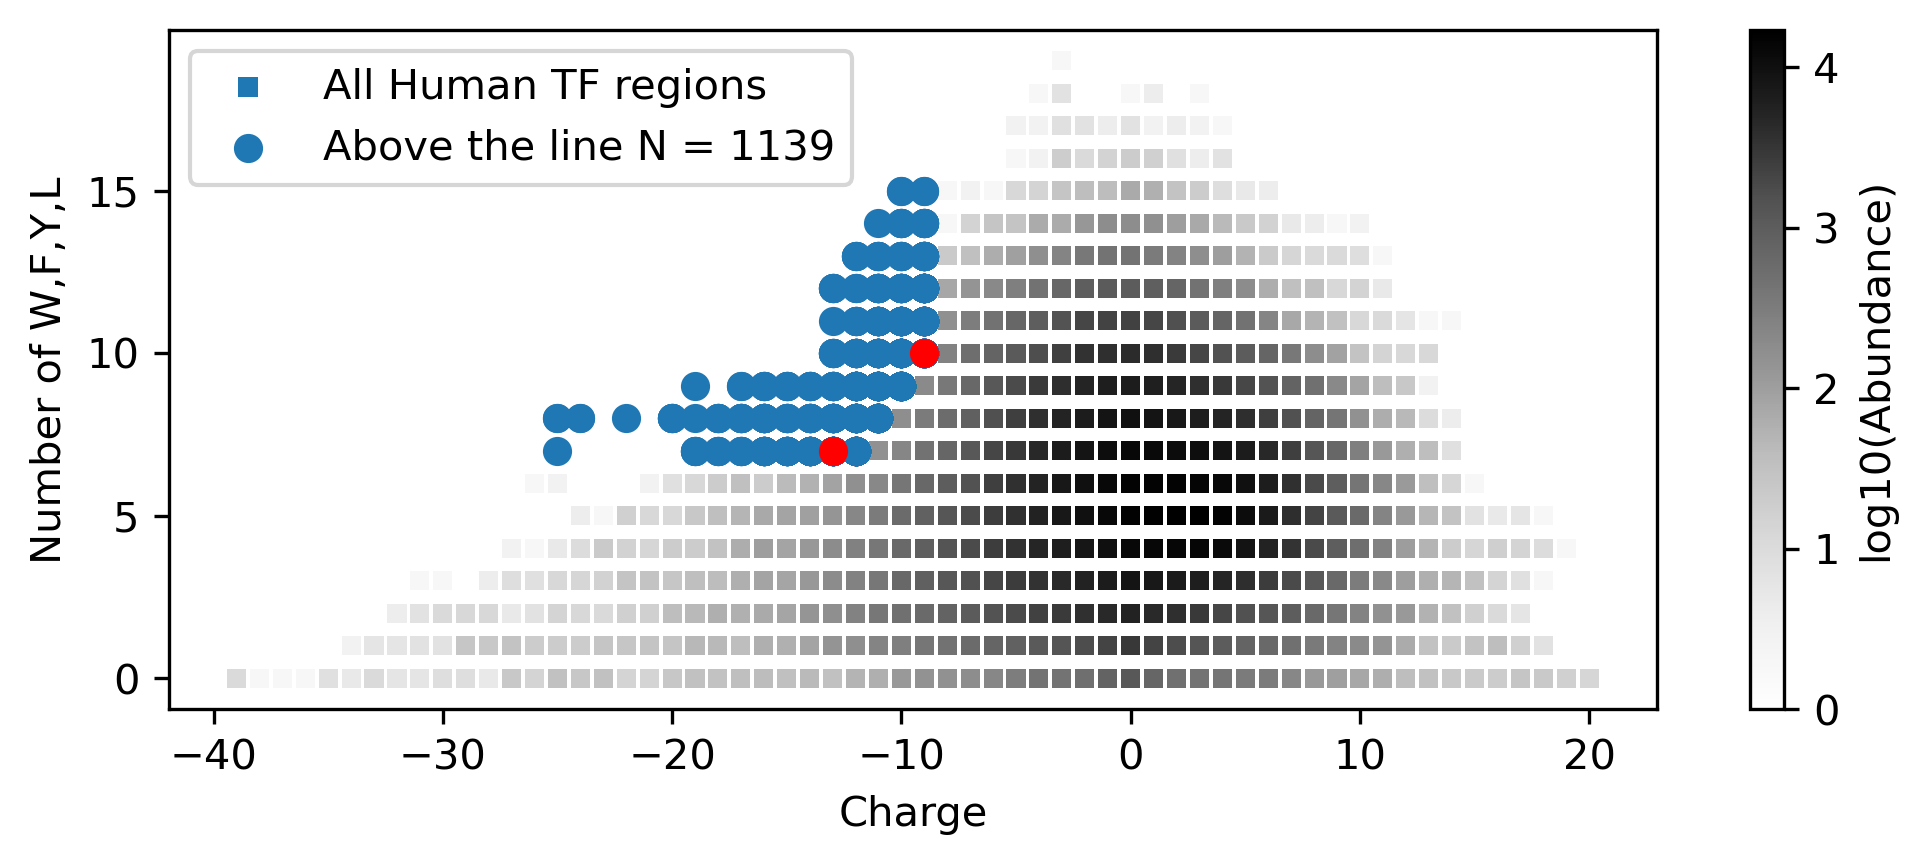

There are 1139 regions of length 39 AA as extreme or more than this AD
These regions come from 136 proteins
sp|P50549|ETV1_HUMAN 	49 AA 	from 35 - 83
sp|Q96AP4|ZUP1_HUMAN 	40 AA 	from 179 - 218
sp|Q03701|CEBPZ_HUMAN 	48 AA 	from 19 - 66
sp|O43524|FOXO3_HUMAN 	45 AA 	from 604 - 648
sp|Q9NQX1|PRDM5_HUMAN 	52 AA 	from 93 - 144
sp|P15172|MYOD1_HUMAN 	50 AA 	from 1 - 50
sp|Q7RTS3|PTF1A_HUMAN 	76 AA 	from 0 - 75
sp|Q05516|ZBT16_HUMAN 	62 AA 	from 78 - 139
sp|Q9NS37|ZHANG_HUMAN 	60 AA 	from 73 - 132
sp|Q86W11|ZSC30_HUMAN 	45 AA 	from 88 - 132
sp|P78413|IRX4_HUMAN 	42 AA 	from 248 - 289
sp|Q13398|ZN211_HUMAN 	58 AA 	from 26 - 83
sp|Q8WTR7|ZN473_HUMAN 	129 AA 	from 0 - 128
sp|P54274|TERF1_HUMAN 	51 AA 	from 43 - 93
sp|Q16665|HIF1A_HUMAN 	41 AA 	from 532 - 572
sp|P0CG23|ZN853_HUMAN 	58 AA 	from 293 - 350
sp|O15060|ZBT39_HUMAN 	62 AA 	from 273 - 334
sp|Q8NEP9|ZN555_HUMAN 	41 AA 	from 6 - 46
sp|O75461|E2F6_HUMAN 	42 AA 	from 142 - 183
sp|Q9UID6|ZN639_HUMAN 	41 AA 	from 293 - 333
sp|Q9BYE7|PCGF6_HU

,GeneName,Start,End,Length,RegionType,ProteinRegionSeq
0,sp|P50549|ETV1_HUMAN,36,83,47,Prediction,RDLAHDSEELFQDLSQLQETWLAEAQVPDNDEQFVPDYQAESLAFHG
1,sp|Q96AP4|ZUP1_HUMAN,180,218,38,Prediction,LDIPLEDCDQPLYDCPMCGLICTNYHILQEHVDLHLEE
2,sp|Q03701|CEBPZ_HUMAN,20,66,46,Prediction,AVEDPDEEDEDNTSEAENGFSLEEVLRLGGTKQDYLMLATLDENEE
3,sp|O43524|FOXO3_HUMAN,605,648,43,Prediction,KFPSDLDLDMFNGSLECDMESIIRSELMDADGLDFNFDSLIST
4,sp|Q9NQX1|PRDM5_HUMAN,94,144,50,Prediction,NLAAIQEGENIFYLAVEDIETDTELLIGYLDSDMEAEEEEQQIMTV...
...,...,...,...,...,...,...
139,sp|Q15596|NCOA2_HUMAN,1058,1097,39,Prediction,SPDDLLCPHPAAESPSDEGALLDQLYLALRNFDGLEEID
140,sp|Q8WYA1|BMAL2_HUMAN,587,636,49,Prediction,EPLLSDGAQLDFDALCDNDDTAMAAFMNYLEAEGGLGDPGDFSDIQWTL
141,sp|Q8IWY8|ZSC29_HUMAN,59,97,38,Prediction,LLVLEQFLTVLPGEIQNWVQEQCPENGEEAVTLVEDLE
142,sp|P01100|FOS_HUMAN,208,246,38,Prediction,DLGFPEEMSVASLDLTGGLPEVATPESEEAFTLPLLND


In [6]:
# ------------------------------------------------------------------------------------------
# This is the main prediction function. 
PredictedTiles = maskproteome(AAlist, lineparameters=[[-9,10],[-13,7],[-9,10]])
#[-9,10] is CITED2
#[-13,7] is VP16

AggregateTilesIntoPredictedADs(Sequences_to_Test,PredictedTiles,exportfilename)
# ------------------------------------------------------------------------------------------